The code below trys to explore the last 2 bullet points of analyzing the history data. 

I followed the code that I found online:
https://medium.com/analytics-vidhya/implementation-of-principal-component-analysis-pca-in-k-means-clustering-b4bc0aa79cb6

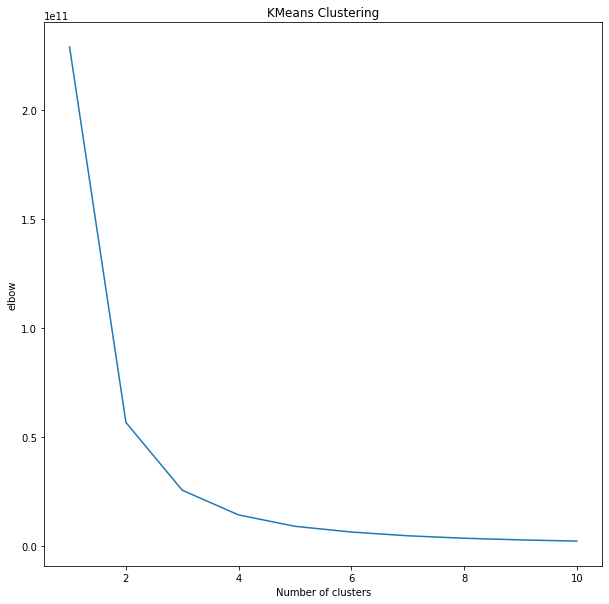

In [1]:
#lets look at k-means 
#finding appropriate number of clusters 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
%matplotlib inline 

#read in and process the data 
history = pd.read_csv("user_history.csv")#.drop(['USER ID'],axis=1)
user_history=history
user_ratings = pd.read_csv("user_ratings.csv")
user_ratings_table = pd.pivot_table(user_ratings,values='RATING', index='USER ID',
                    columns='PRODUCT')
#using elbow method to find optimal number of clusters to partition history data
elbow = []
for i in range(1,11):
    kmodel = KMeans(n_clusters = i, init = "k-means++")
    kmodel.fit(history)
    elbow.append(kmodel.inertia_)
plt.figure(figsize=(10,10))
plt.title('KMeans Clustering')
plt.plot(range(1,11), elbow)
plt.xlabel('Number of clusters')
plt.ylabel('elbow')
plt.show()

From graph we can see that the optimal number of clusters to partition the history data is 3. 



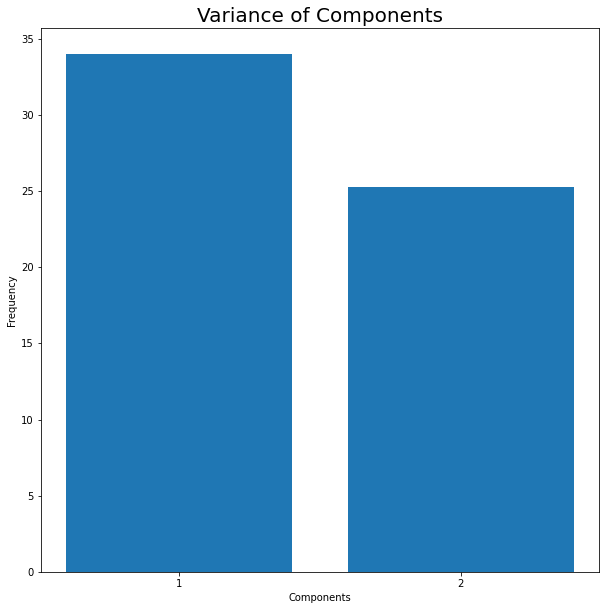

Explained variation per principal component: [0.33984813 0.25309902]


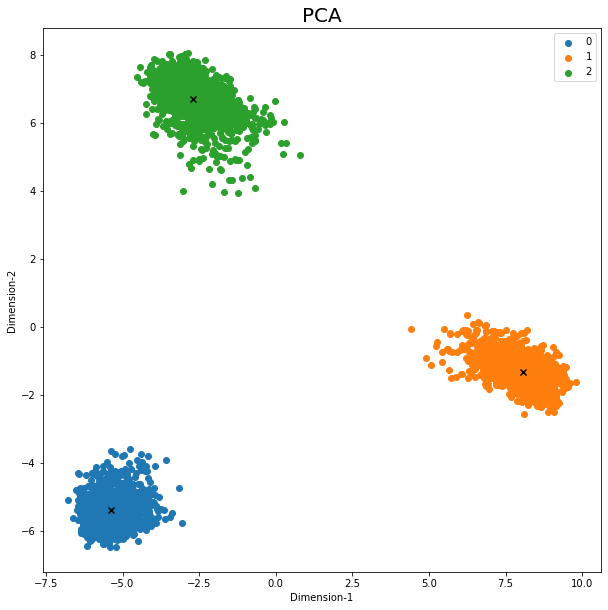

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import cluster

#change data into 2-dimensions
pca = PCA(2)
history = StandardScaler().fit_transform(history)
data = pca.fit_transform(history)

#check variance of components 
plt.figure(figsize=(10,10))
v = np.round(pca.explained_variance_ratio_*100, decimals = 1)
labels = [str(x) for x in range(1,len(v)+1)]
plt.title('Variance of Components', fontsize = 20)
plt.bar(x=range(1,len(v)+1), height = v, tick_label = labels)
plt.xlabel('Components')
plt.ylabel('Frequency')
plt.show()

#table of principle components 
his_pca = pd.DataFrame(data = data, columns = ['principal component 1', 'principal component 2'])
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

#train k means and pca
kmeans = cluster.KMeans(3)
kmeans.fit(data)
#Find the centeroids of the 3 clusters 
centers = np.array(kmeans.cluster_centers_)
model = KMeans(n_clusters = 3, init = "k-means++")
label = model.fit_predict(data)

#creating PCA graph
plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)
plt.scatter(centers[:,0], centers[:,1], marker="x", color='k')
plt.legend()
plt.title('PCA', fontsize = 20)
plt.xlabel('Dimension-1')
plt.ylabel('Dimension-2')
plt.show()

In [3]:
#taking out the clusters from above and reformatting them
all_data=pd.merge(user_history,user_ratings_table,right_index=True,left_on='USER ID',how='outer' )
all_data['cluster']=label
cluster_0=all_data[all_data['cluster']==0]
cluster_1=all_data[all_data['cluster']==1]
cluster_2=all_data[all_data['cluster']==2]

In [4]:
#looking at the 3 clusters 
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline

#creating model
reg = make_pipeline(StandardScaler(),SGDRegressor(max_iter=1000, tol=1e-3))
products=user_ratings_table.columns

#models for each cluster
ID=cluster_0['USER ID'] #IDs that are in cluster 0
df0=pd.DataFrame(ID)
for i in range(101,176):#for loop to iterate through each product
    product=products[i-101]
    X=cluster_0.iloc[:,0:101]
    Y=cluster_0.iloc[:,[0,i]]
    Y=Y[~Y.iloc[:,1].isna()]#indexes the user history to only include users that already have a rating for that product
    data=pd.merge(X,Y,how='inner')
    feature=data.iloc[:,1:101]
    target=data.iloc[:,-1]
    reg.fit(feature, target)#fits the model for the users that already include ratings for the product being looked at
    features=cluster_0.iloc[:,1:101]
    prediction=reg.predict(features) #uses model to predict ratings for all other users
    df0[product]=prediction
#print(df0)

#repeats the same process for the other two clusters
ID=cluster_1['USER ID']
df1=pd.DataFrame(ID)
for i in range(101,176):
    product=products[i-101]
    X=cluster_1.iloc[:,0:101]
    Y=cluster_1.iloc[:,[0,i]]
    Y=Y[~Y.iloc[:,1].isna()]
    data=pd.merge(X,Y,how='inner')
    feature=data.iloc[:,1:101]
    target=data.iloc[:,-1]
    reg.fit(feature, target)
    features=cluster_1.iloc[:,1:101]
    prediction=reg.predict(features)
    df1[product]=prediction
#print(df1)

ID=cluster_1['USER ID']
df2=pd.DataFrame(ID)
for i in range(101,176):
    product=products[i-101]
    X=cluster_2.iloc[:,0:101]
    Y=cluster_2.iloc[:,[0,i]]
    Y=Y[~Y.iloc[:,1].isna()]
    data=pd.merge(X,Y,how='inner')
    feature=data.iloc[:,1:101]
    target=data.iloc[:,-1]
    reg.fit(feature, target)
    features=cluster_2.iloc[:,1:101]
    prediction=reg.predict(features)
    df2[product]=prediction
#print(df2)

In [5]:
#creating single data frame of all ratings from the 3 clusters
merged=pd.merge(pd.merge(df0,df1),df2)
merged=pd.merge(pd.merge(df0,df1,how='outer'),df2,how='outer')
#reformatting the dataframe into the appropriate format 
rate= merged.melt(id_vars=['USER ID'], var_name='PRODUCT', value_name='RATING')
rate = rate.set_index('USER ID')
rate['RATING'] = rate['RATING'].round(0)
print(rate)
rate.to_csv('predictions.csv')

               PRODUCT  RATING
USER ID                       
100956   adrian crater     3.0
100978   adrian crater     5.0
100982   adrian crater     9.0
100986   adrian crater     9.0
101014   adrian crater     3.0
...                ...     ...
125562    wheel gibson     1.0
125574    wheel gibson     3.0
125614    wheel gibson     4.0
125636    wheel gibson     5.0
125645    wheel gibson     6.0

[337500 rows x 2 columns]


In [6]:
#testing accuracy 
from sklearn import metrics
ur = pd.read_csv("user_ratings.csv")
ur = ur.set_index('USER ID')
ur['RATING'] = ur['RATING'].astype(float)
combine = pd.merge(rate, ur, how = 'inner', on =['USER ID', 'PRODUCT'])
print(combine)
accuracy = metrics.accuracy_score(combine['RATING_x'].astype(int),combine['RATING_y'].astype(int))
print(accuracy)

               PRODUCT  RATING_x  RATING_y
USER ID                                   
100982   adrian crater       9.0       9.0
100986   adrian crater       9.0       9.0
101118   adrian crater       3.0       3.0
101195   adrian crater       8.0       8.0
101239   adrian crater       3.0       3.0
...                ...       ...       ...
116999    wheel gibson       6.0       0.0
117005    wheel gibson       6.0       6.0
117005    wheel gibson       4.0       6.0
117109    wheel gibson      10.0      10.0
117109    wheel gibson       2.0      10.0

[33815 rows x 3 columns]
0.5828182759130563


In [7]:
from sklearn.metrics import r2_score
user_ratings_table.reset_index(level=0, inplace=True)

rating_test = []
prediction_test = []

user_rating_list = user_ratings_table.values.tolist()
merged_list = merged.values.tolist()



rating_test = user_ratings_table[['USER ID','adrian crater']]

rating_test = pd.DataFrame(rating_test)
rating_test.set_index('USER ID',inplace=True)

prediction_test = merged[['USER ID','adrian crater']]
prediction_test = pd.DataFrame(prediction_test)
prediction_test.set_index('USER ID',inplace=True)

rating_test=rating_test.dropna()



tester=rating_test.merge(prediction_test,on='USER ID',how='inner')


test1 = tester['adrian crater_x']
test2 = tester['adrian crater_y']
r = r2_score(test1, test2)

print("R-Squared value is", r)

R-Squared value is 0.12599041978234937
